Importing Libraries


In [28]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=429cee40af121b504e15427a658b6a077b08b609fe9c0558c0b385f364e46d3a
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [29]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [30]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [ ]:
pyoff.init_notebook_mode()

NameError: ignored

In [31]:
tx_data = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

In [32]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


read data from csv and redo the data work we done before

In [33]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])


In [34]:
tx_uk = tx_data.query("Country == 'United Kingdom'").reset_index(drop=True)

In [ ]:
date( 2007, 12, 5)

datetime.date(2007, 12, 5)

create 3m and 6m dataframes

In [35]:
tx_6m = tx_uk[(tx_uk.InvoiceDate.dt.date >= date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date < date(2011,12,1))].reset_index(drop=True)

tx_3m = tx_uk[(tx_uk.InvoiceDate.dt.date < date(2011,6,1)) & (tx_uk.InvoiceDate.dt.date >= date(2011,3,1))].reset_index(drop=True)

In [36]:
tx_3m['InvoiceDate'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                   95193
unique                   4852
top       2011-04-18 13:13:00
freq                      333
first     2011-03-01 08:30:00
last      2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

create tx_user for assigning clustering

In [37]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']


order cluster method

In [38]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

calculate recency score

In [39]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()


In [40]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [41]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days


In [42]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')


In [43]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

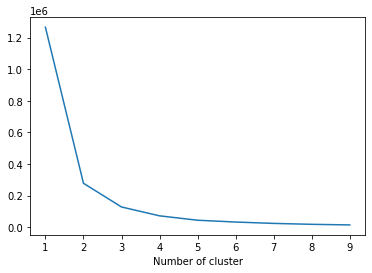

In [44]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [45]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [46]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
1,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
2,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
3,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0


In [47]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

calcuate frequency score

In [48]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

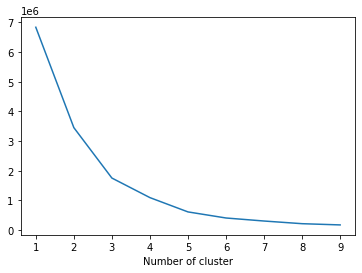

In [49]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [50]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [51]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,24.218069,17.761893,1.0,10.0,20.0,36.0,70.0
1,11.0,496.000000,125.912668,331.0,422.5,452.0,570.0,730.0
2,223.0,116.560538,43.816927,71.0,83.5,104.0,131.5,285.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.0,1364.0


In [52]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calculate revenue and create a new dataframe for it

In [53]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [54]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.Revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

In [55]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

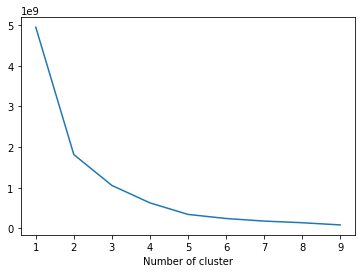

In [56]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [57]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1714.0,469.943256,389.245612,-1462.50,199.9275,340.340,626.8900,1763.04
1,114.0,3084.445096,1510.691906,1779.43,1987.9125,2559.095,3483.3075,7969.99
2,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


#Overall Segmentation

In [58]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [59]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,77.009009,18.441441,286.345465
1,50.990476,24.476190,370.358286
2,26.614833,30.765550,493.844187
3,10.329897,36.298969,616.318495
4,8.850877,96.456140,1990.659219
5,6.529412,121.509804,3288.066863
6,7.625000,329.125000,10894.470000
7,3.000000,779.333333,11350.896667


In [60]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    333
1    420
2    418
3    485
4    114
5     51
6     16
7      3
Name: Recency, dtype: int64

In [61]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [62]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [63]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [64]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#LTV

In [65]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


In [66]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [67]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


plot LTV histogram

In [68]:
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#merge our 3 months and 6 months dataframes to see correlations between LTV and the feature set we have.

In [69]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)
tx_merge.groupby('Segment')['m6_Revenue'].mean()


Segment
High-Value    12830.780571
Low-Value       703.188463
Mid-Value      1663.151220
Name: m6_Revenue, dtype: float64

In [70]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Data Prep for Training

removing outliers

In [71]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

creating 3 clusters

In [72]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creating a new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


There are few more step before training the machine learning model:

Need to do some feature engineering. We should convert categorical columns to numerical columns.
We will check the correlation of features against our label, LTV clusters.
We will split our feature set and label (LTV) as X and y. We use X to predict y.
Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.

In [73]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

Lines related to correlation make us have the data below

In [74]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending = False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.491743
OverallScore          0.383799
FrequencyCluster      0.366366
Segment_High-Value    0.362014
Frequency             0.359601
RecencyCluster        0.236899
Segment_Mid-Value     0.136554
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266195
Name: LTVCluster, dtype: float64

#XGBoost Multiclassification Model

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.84


In [77]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        70
           1       0.64      0.39      0.48        18
           2       0.40      0.50      0.44         4

    accuracy                           0.84        92
   macro avg       0.64      0.62      0.62        92
weighted avg       0.82      0.84      0.82        92

